# Анализ поведения пользователей мобильного приложения

**Целью исследования** является изучение поведения пользователей мобильного приложения.  
Мы изучим воронку продаж и определим ее слабые места, а исследование результатов А/А/В-эксперимента позволит нам определить, оказывает ли изменение шрифта в приложении значимое влияние на показатели конверсии.

**Этапы исследования:**

1. Обзор данных
2. Предобработка данных
3. Анализ и проверка данных  
4. Анализ воронки событий
5. Анализ результатов эксперимента

<a name="h1"></a>
### 1. Обзор данных

#### Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas.plotting as pdplt
pdplt.register_matplotlib_converters()

import seaborn as sns

import numpy as np
import math as mth
from scipy import stats as st

#### Настройка

In [2]:
#отображение данных до двух знаков после запятой
pd.set_option('display.precision', 2)

#вывод всех значений ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#pd.options.display.max_colwidth = 100

#### Анализ файла

In [3]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\s+')

In [4]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод**  
Представлена информация о 244 126 действиях пользователей. Для каждого события указано его название, уникальный идентификатор пользователя, время события и один из трех возможных номеров группы.  
Пропущенных данных нет, однако необходимо изменить тип данных в столбце `EventTimestamp` и переименовать столбцы. Также стоит проверить данные на наличие дубликатов.

<a name="h2"></a>
### 2. Предобработка данных

- Переименуем столбцы.

In [6]:
df.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [7]:
df.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

- Проверим данные на наличие пропусков

In [8]:
df.isnull().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

- Проверим данные на наличие дубликатов.

In [9]:
df.duplicated().sum()
np.round(df.duplicated().sum() / len(df), 3)

413

0.002

Дубликаты составляют менее 0,2% от всей выборки. Удалим их.

In [10]:
df = df.drop_duplicates()

- На основании столбца `event_timestamp` добавим новые столбцы: только с датой, с датой и временем.  

In [11]:
df['datetime'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [12]:
df['date'] = pd.to_datetime(df['datetime'], format='%Y%m%d').dt.floor('D')

- Удалим столбец `event_timestamp`.

In [13]:
del df['event_timestamp']

Посмотрим, что получилось.

In [14]:
df.head()

,event_name,device_id_hash,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
event_name        243713 non-null object
device_id_hash    243713 non-null int64
exp_id            243713 non-null int64
datetime          243713 non-null datetime64[ns]
date              243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


**Результат**  
1. Столбцы переименованы.
2. Подтверждено отсутствие пропусков.
3. Исключены дубликаты.
3. Добавлены столбцы: только с датой события и с датой и временем события.

<a name="h3"></a>
### 3. Анализ и проверка данных

In [16]:
print('Всего событий в логе:', len(df))

Всего событий в логе: 243713


In [17]:
print('Всего уникальных пользователей в логе:', df['device_id_hash'].nunique())

Всего уникальных пользователей в логе: 7551


In [18]:
print('На одного пользователя в среднем приходится', round(len(df) / df['device_id_hash'].nunique()), 'события')

На одного пользователя в среднем приходится 32 события


In [19]:
print('Представлены данные за', 
      str(df['date'].max() - df['date'].min()).split()[0], 'дней, в период с', 
      df['date'].min().strftime("%d.%m.%Y"), 'по', 
      df['date'].max().strftime("%d.%m.%Y"))

Представлены данные за 13 дней, в период с 25.07.2019 по 07.08.2019


- Построим гистограмму по дате и времени

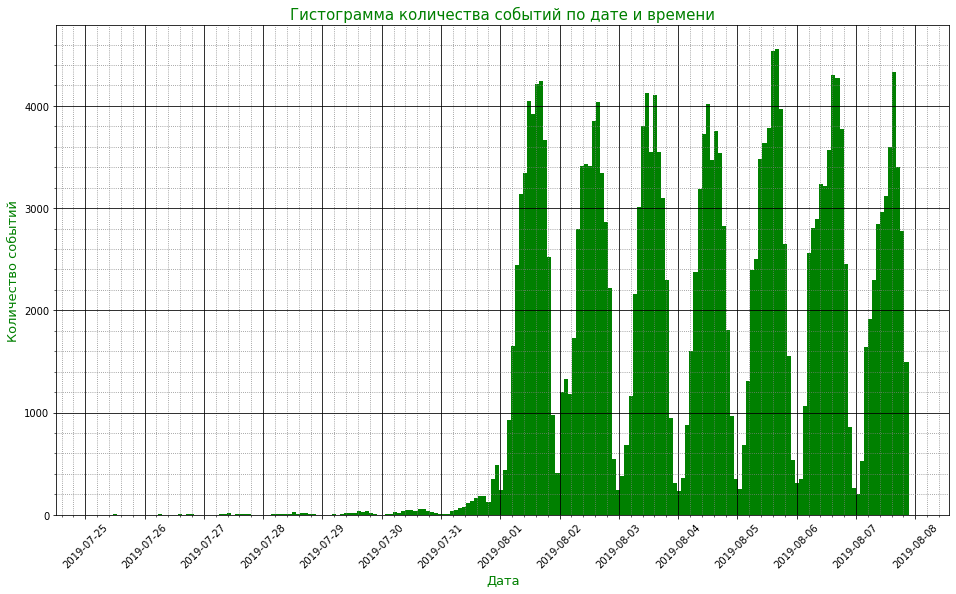

In [20]:
ax = df['datetime'].hist(bins = 200, figsize = (16,9), color='green')
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

ax.grid(which='major',
        color = 'k')
ax.minorticks_on()
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')

plt.title("Гистограмма количества событий по дате и времени", fontsize=15, color='green')
plt.xlabel("Дата", fontsize=13, color='green')
plt.ylabel("Количество событий", fontsize=13, color='green')

plt.show();

На графике видно, что в нашем распоряжении есть полные данные только за последние 7 дней: с 01-08-2019 по 07-08-2019. Исключим дни с неполными данными.  
Одновременно можно отметить, что гистограммы в рамках одних суток по оставшимся дням указывают на нормальное распределение данных, что необходимо учитывать при дальнейшем тестировании.

In [21]:
df_net = df[(df['datetime'] >= '2019-08-01 00:00:00')]

In [22]:
print('Количество событий, исключенных из лога:', 
      (len(df) - len(df_net)), 'или', 
      round((len(df) - len(df_net)) * 100 / len(df)), '%')

Количество событий, исключенных из лога: 2826 или 1 %


In [23]:
print('Количество уникальных пользователей, исключенных из лога:', 
      (df['device_id_hash'].nunique() - df_net['device_id_hash'].nunique()), 'или', 
     round((df['device_id_hash'].nunique() - df_net['device_id_hash'].nunique()) *100 / df['device_id_hash'].nunique(), 2), '%')

Количество уникальных пользователей, исключенных из лога: 17 или 0.23 %


- Проверим, что в выборке есть пользователи из всех трех экспериментальных групп. 

In [24]:
df_net['exp_id'].unique()

array([246, 247, 248])

**Вывод**  
После очистки данных анализируемый период сократился почти в 2 раза: с 13 до 7 дней, при этом мы потеряли всего 1% событий и 0,23% от всех уникальных пользователей.

<a name="4"></a>
### 4. Анализ воронки событий

- Рассмотрим какие события есть в логах и как часто они встречаются.

In [25]:
df_event = df_net.groupby('event_name').agg({'device_id_hash':'count'}).reset_index()

In [26]:
#напишем функцию для создания графиков типа sns.barplot
def sns_barplot(x, y, data, x_label="", y_label="", title=""):
    plt.figure(figsize=(16,9))
    ax = sns.barplot(x=x, y=y, data=data.sort_values(y, ascending=False), palette=sns.color_palette("BuGn_r",  len(data)))

    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height):
            height = 0
        ax.text(p.get_x() + p.get_width()/2., height, '%d' % int(height), 
            fontsize=11, color='black', ha='center', va='bottom')
    
    plt.title(title, fontsize = 15, fontweight="bold", color='green')
    plt.xlabel(x_label, fontsize = 13, fontweight=500, color='green')
    plt.ylabel(y_label, fontsize = 13, fontweight=500, color='green')

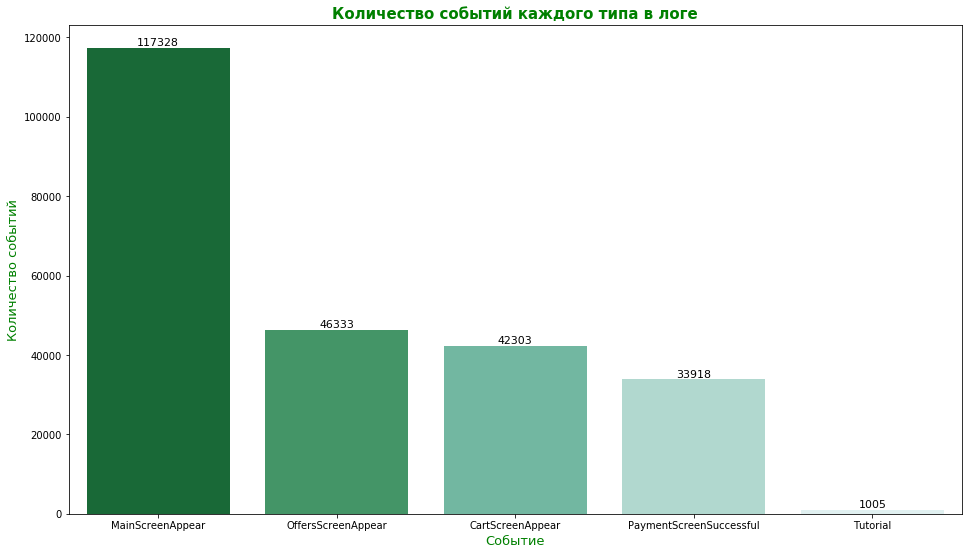

In [27]:
sns_barplot('event_name', 'device_id_hash', df_event, 
            x_label="Событие", y_label="Количество событий", title="Количество событий каждого типа в логе")

- Рассмотрим сколько пользователей совершали каждое из этих событий.

In [28]:
df_id = df_net.groupby('event_name').agg({'device_id_hash':'nunique'}).reset_index()

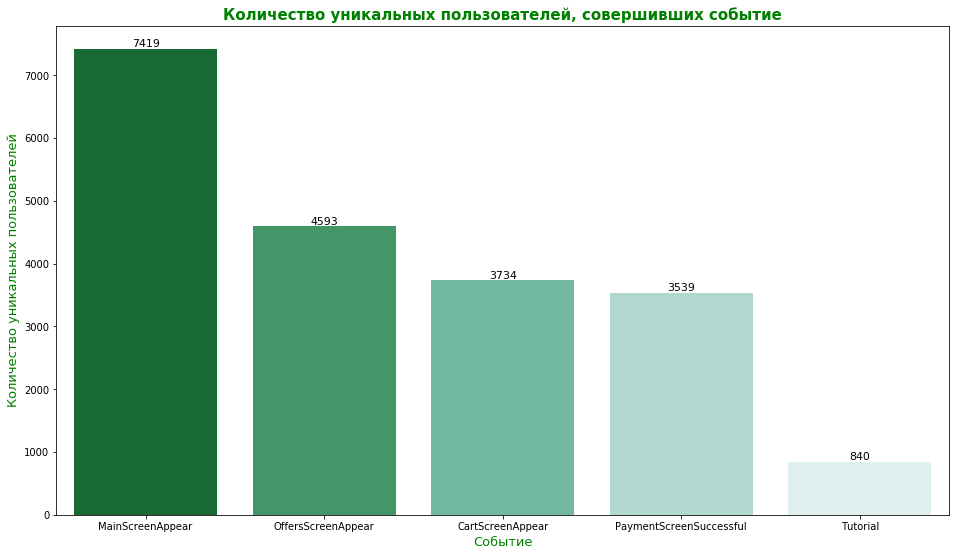

In [29]:
sns_barplot('event_name', 'device_id_hash', df_id, 
            x_label="Событие", y_label="Количество уникальных пользователей", 
            title="Количество уникальных пользователей, совершивших событие")

Для каждого события рассчитаем количество и долю пользователей, которые хоть раз его совершали.

In [30]:
df_id['users_share'] = df_id['device_id_hash'] / df_net['device_id_hash'].nunique()

In [31]:
df_id.columns = ['event_name', 'users_amount', 'users_share']

In [32]:
df_id = df_id.sort_values('users_share', ascending=False)
df_id

,event_name,users_amount,users_share
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


Исходя из полученной информации можно определить логичный порядок событий:
    - просмотр главной страницы;
    - переход на страницу с товарами;
    - переход в корзину;
    - оплата.  
Этап ознакомление с инструкцией не является обязательным, так как всего 11% пользователей заходят на эту страницу, при этом этот показатель самый низкий среди всех событий. Поскольку чтение инструкции уже после совершения всех действий в мобильном приложении не имеет смысла (что объяснило бы самый низкий охват как для последнего этапа воронки), можно исключить данный пункт при расчете воронки.   

In [33]:
df_id = df_id.drop([4])

- Определим на каком шаге теряется больше всего пользователей, рассчитав конверсию методом `shift`

In [34]:
df_id['conversion'] = df_id.users_amount / df_id.users_amount.shift(1)

In [35]:
df_id

,event_name,users_amount,users_share,conversion
1,MainScreenAppear,7419,0.98,NaN
2,OffersScreenAppear,4593,0.61,0.62
0,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


Самая низкая конверсия при переходе от главной страницы к странице с товарами.

In [36]:
print('Доля пользователей, посетивших главную страницу и дошедших до этапа оплаты заказа:', 
      np.round((df_id.iloc[3,1] / df_id.iloc[0,1]), 2))

Доля пользователей, посетивших главную страницу и дошедших до этапа оплаты заказа: 0.48


**Вывод**  
98% всех пользователей заходили на главную страницу, при этом только 62% из них переходили на страницу с товарами. 4 из 5 просмотревших каталог, добавляли товар в корзину и почти каждый пользователь (95%) после этого шага оплатил покупку. Из-за низкой конверсии при переходе от главной страницы к странице с товарами, покупателем становился только каждый второй пользователь (48%), посетивший главную страницу. При этом некоторые пользователи открывали католог минуя главную страницу - их доля составила 2%.  Вероятно, они попадали на сайт через контекстную рекламу сразу на страницу с предлагаемым товаром.  
Самый низкий показатель конверсии при переходе от главной страницы к каталогу. Возможно, дело в недостаточно удобной навигации по сайту, из-за которой некоторые пользователи не находят ссылку на страницу с товарами или были технические сбои, непозволившие потенциальным покупателям совершить переход на страницу с катологом. Можно обратить внимание коллег на данный факт, чтобы подробнее изучить логи:  
- Проверить время, которое пользователи проводят на главной странице, и если оно слишком большое это может быть признаком проблем с интерфейсом приложения.
- Посмотреть как распределена конверсия по дням/операционным системам/типам устройств. Существенное изменение показателя в разрезе дней/операционных систем/типов устройста при прочих равных условиях может говорить о наличии технических проблем.

<a name="5"></a>
### 5. Анализ результатов эксперимента

Прежде всего исключим из датафрейма этап по ознакомлению с инструкцией.

In [37]:
df_net_final = df_net[df_net['event_name'] != 'Tutorial']

Рассчитаем количество уникальных пользователей в каждой из трех групп. 

In [38]:
check = df_net_final.groupby('exp_id').agg({'device_id_hash':'nunique'}).reset_index()
check

,exp_id,device_id_hash
0,246,2483
1,247,2512
2,248,2535


Проверим данные для А/А-теста:

- Убедимся, что каждый пользователь попадает только в одну экспериментальную группу.

In [39]:
#группируем данные по каждому пользователю, агрегируя по количеству экспериментальных групп 
#проверяем, что этот показатель ни для одного пользователя не превышает 1
check_2 = df_net_final.groupby('device_id_hash').agg({'exp_id':'nunique'}).reset_index()
check_2['exp_id'].max()

1

- Получим подтверждение, что количество пользователей в различных группах различается не более, чем на 1%;

In [40]:
print('Отношение количества пользователей в группе 246 к количеству пользователей в группе 247:', 
      np.round((check.iloc[0,1] / check.iloc[1,1]), 2))

Отношение количества пользователей в группе 246 к количеству пользователей в группе 247: 0.99


Наши данные подходят для проведения А/А-теста. Приступим к тестированию. 

Начнем со сводной таблицы, в которой сгруппируем данные по событиям и экспериментальным группам. Агрегировать данные будем по количеству уникальных пользователей.

In [41]:
pivot = df_net_final.pivot_table(index='event_name', columns='exp_id', 
                         values='device_id_hash', aggfunc='nunique').sort_values(246, ascending=False).reset_index()
pivot

exp_id,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Создадим столбец `246&247`, в котором объединим данные контрольных групп.

In [42]:
pivot['246&247'] = pivot[246] + pivot[247]
pivot

exp_id,event_name,246,247,248,246&247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


Пропишем функцию для формулирования и проверки гипотез для различных групп и событий. Ранее мы отметили нормальность распределения данных, поэтому воспользуемся `z-тестом`, который обычно применяют для проверки гипотезы о равенстве долей двух генеральных совокупностей. В качестве параметров функции будут указываться: 
- номер группы №1, 
- номер группы №2, 
- наименование датафрейма,
- критический уровень статистической значимости.

In [43]:
def z_test(group1, group2, data, alpha): 
    
    alpha = alpha # критический уровень статистической значимости
    
    if group1 == 246 and group2 == 247:
        id_amount = [2483, 2512]
    elif group1 == 246 and group2 == 248:
        id_amount = [2483, 2535]
    elif group1 == 247 and group2 == 248:    
        id_amount = [2512, 2535]       
    else:
        id_amount = [2483+2512, 2535]                    
     
    for event in range(0, len(data)):
        successes = np.array([data.loc[event, group1], data.loc[event, group2]])
        trials = np.array([id_amount[0], id_amount[1]])

    # пропорция успехов в каждой группе:
        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
        difference = p1 - p2
   
    # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        print(distr)
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        event = data.loc[event, 'event_name']
        print('Нулевая гипотеза H₀: конверсии группы', group1, 'и группы', group2, 'по событию', event, 'равны.')
        print('Альтернативная гипотеза H₁: конверсии группы', group1, 'и группы', group2,'по событию', event, 'различаются.')
        print('p-значение: ', round(p_value, 2))
    
        if (p_value < alpha):
             print("Отвергаем нулевую гипотезу: между конверсиями есть значимая разница")
        else:
             print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными")
        print('---------------------------------------------------------------------------------------------------------------')

#### Гипотеза 1: существует статистическая значимость различий в конверсии событий между контрольными группами 246 и 247 (уровень стат. значимости 1%)

In [44]:
z_test(246, 247, pivot, 0.01)

Нулевая гипотеза H₀: конверсии группы 246 и группы 247 по событию MainScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246 и группы 247 по событию MainScreenAppear различаются.
p-значение:  0.75
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------
Нулевая гипотеза H₀: конверсии группы 246 и группы 247 по событию OffersScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246 и группы 247 по событию OffersScreenAppear различаются.
p-значение:  0.25
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------
Нулевая гипотеза H₀: конверсии группы 246 и группы 247 по событию CartScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246 и группы 247 по событию CartScreenAppear разл

**Вывод**  
При 1% уровне значимости нет оснований считать конверсии групп 246 и 247 разными ни по одному из событий. Можно сделать вывод, что разбиение на группы сработало корректно.

#### Гипотеза 2: существует статистическая значимость различий в конверсии событий между контрольной группой 246 и экспериментальной группой 248 (уровень стат. значимости 1%)

In [45]:
z_test(246, 248, pivot, 0.01)

Нулевая гипотеза H₀: конверсии группы 246 и группы 248 по событию MainScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246 и группы 248 по событию MainScreenAppear различаются.
p-значение:  0.34
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------
Нулевая гипотеза H₀: конверсии группы 246 и группы 248 по событию OffersScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246 и группы 248 по событию OffersScreenAppear различаются.
p-значение:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------
Нулевая гипотеза H₀: конверсии группы 246 и группы 248 по событию CartScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246 и группы 248 по событию CartScreenAppear разл

**Вывод**  
При 1% уровне значимости нет оснований считать конверсии групп 246 и 248 разными ни по одному из событий.

#### Гипотеза 3: существует статистическая значимость различий в конверсии событий между контрольной группой 247 и экспериментальной группой 248 (уровень стат. значимости 1%)

In [46]:
z_test(247, 248, pivot, 0.01)

Нулевая гипотеза H₀: конверсии группы 247 и группы 248 по событию MainScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 247 и группы 248 по событию MainScreenAppear различаются.
p-значение:  0.52
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------
Нулевая гипотеза H₀: конверсии группы 247 и группы 248 по событию OffersScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 247 и группы 248 по событию OffersScreenAppear различаются.
p-значение:  0.93
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------
Нулевая гипотеза H₀: конверсии группы 247 и группы 248 по событию CartScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 247 и группы 248 по событию CartScreenAppear разл

**Вывод**  
При 1% уровне значимости нет оснований считать конверсии групп 247 и 248 разными ни по одному из событий.

#### Гипотеза 4: существует статистическая значимость различий в конверсии событий между объединенными контрольными группами 246 и 247 и экспериментальной группой 248 (уровень стат. значимости 1%)

In [47]:
z_test('246&247', 248, pivot, 0.01)

Нулевая гипотеза H₀: конверсии группы 246&247 и группы 248 по событию MainScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246&247 и группы 248 по событию MainScreenAppear различаются.
p-значение:  0.35
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------
Нулевая гипотеза H₀: конверсии группы 246&247 и группы 248 по событию OffersScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246&247 и группы 248 по событию OffersScreenAppear различаются.
p-значение:  0.45
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
---------------------------------------------------------------------------------------------------------------
Нулевая гипотеза H₀: конверсии группы 246&247 и группы 248 по событию CartScreenAppear равны.
Альтернативная гипотеза H₁: конверсии группы 246&247 и группы 248 по событ

**Вывод**  
При 1% уровне значимости нет оснований считать конверсии групп 246&247 и 248 разными ни по одному из событий.

Полученные результаты z-теста говорят нам о том, что при 1% уровне значимости изменение шрифта во всем приложении не оказало влияния на показатели конверсии, при этом значения p-value достаточно велики, чтобы не давать оснований отклонять нулевые гипотезы даже при повышении уровня значимости до 5%, и только при уровне значимости в 10% будут основания отвергнуть нулевую гипотезу по одному из 16 тестов: о том, что конверсии группы 246 и группы 248 по событию CartScreenAppear равны (p-value = 0.08).  
Важно отметить, что увеличение уровня статистической значимости теста также увеличит и вероятность ошибки первого рода: т.е. вероятность ошибочно отклонить нулевую гипотезу, когда различий на самом деле нет, поэтому оснований для увеличения уровня значимости нет. Изменения результатов, полученные вследствие этого шага, скорее всего будут некорректными.

<a name="h6"></a>
### 6. Общий вывод и рекомендации

В ходе исследования были получены результаты и предложены рекомендации ниже:
- *Определена воронка событий и выявлены ее слабые места*   
Наименьшая конверсия зафиксирована от перехода с главной страницы на страницу с товарами. Необходимо провести дополнительные исследования, чтобы убедиться, что интерфейс приложения дружественный и пользователи легко могут найти нужную информацию. Анализ логов позволит исключить или подтвердить наличие возможных технических сбоев/ошибок, которые негативно влияют на конверсию приложения.
- *Изучены результаты А/А/В-эксперимента по внесению изменений в приложение*  
Результаты теста не выявили значимых различий между конверсиями до и после изменения шрифта во всем приложении. Возможно, решение проблемы низкой конверсии кроется не в визуальной составляющей приложения, а в его технической части.